#**<font color='red'>MAKE A COPY TO YOUR GOOGLE DRIVE </font>**
Please make a copy, by navigating to **File > Save a copy in Drive**. This is important as you may lose your progress otherwise.

Once completed, please download as a Python (.py) file and submit on Gradescope (navigate to **File > Download > Download .py**). The file name should be **pset5.py**.


Make sure as you are working through the notebook, you run all the cells as you go along (otherwise your code may produce errors or not work properly). Additionally, your code cells may de-load if the session has been running for too long; please periodically restart your runtime / run all your cells.

In completing the assignment, please complete the functions / classes / variables. Do **NOT** change the names of existing functions / classes / variables and their signature / input (or re-assign / redefine them) as this is what Gradescope parses for. Lastly, do not include or import additional libraries beyond the ones provided for the final submission (as Gradescope will reject them).

# Problem Set 5 (65 pts)

In this problem set, you'll explore topics in deep learning for computer vision.

You will be designing and training neural networks. Training these neural networks can take some time so you might run into some issues with your Colab session deloading. Some suggestions to address this:
- Use GPU runtime to speed up training. To activate GPU runtime, go to the top menu bar > Runtime > Change runtime type > Select GPU. This will make a significant difference (can be 10-50x faster with GPUs)
- Make sure to run the data loading and prep cell each time if and when the session deloads, otherwise you won't have any data to work with
- Run each neural network separately; each network can be trained independently of the other (as long as the data prep is loaded). Thus, if one section is done, you don't need to re-run it again to move to the next session in the case your session deloaded.
- An alternative solution is to download the notebook and use your local machine (which has no time constraints). However, this is a more advanced option and may require some setup and configuration



In [1]:
### DO NOT CHANGE ###
# importing the libraries (do not remove or add libraries)
import numpy as np
import tensorflow as tf

## Context & Data Preparation

You're working as a Machine Learning lead for a computer vision based drone start-up. The start-up has been contracted by the US National Park Services to monitor and track plant species in the US National Parks.

As the Machine Learning lead, you need to prepare vision-based machine learning models that can accurately identify different plant species. As an initial proof-of-concept, you'll be building models for classifying different flowers using a dataset provided by your team. This will be invaluable for the start-up to automatically analyze and label drone footage of the park.

In this problem set, you'll experiement with the following approaches:
- Feed Forward Neural Network
- Convolutional Neural Network
- Transfer Learning


Run the below **Data Overview** cell to load / prep in your data, print out some summary information, and visualize some examples from your dataset. **<font color='red'>Note: you must run the below cell, otherwise the later parts of the notebook won't run.</font>**

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


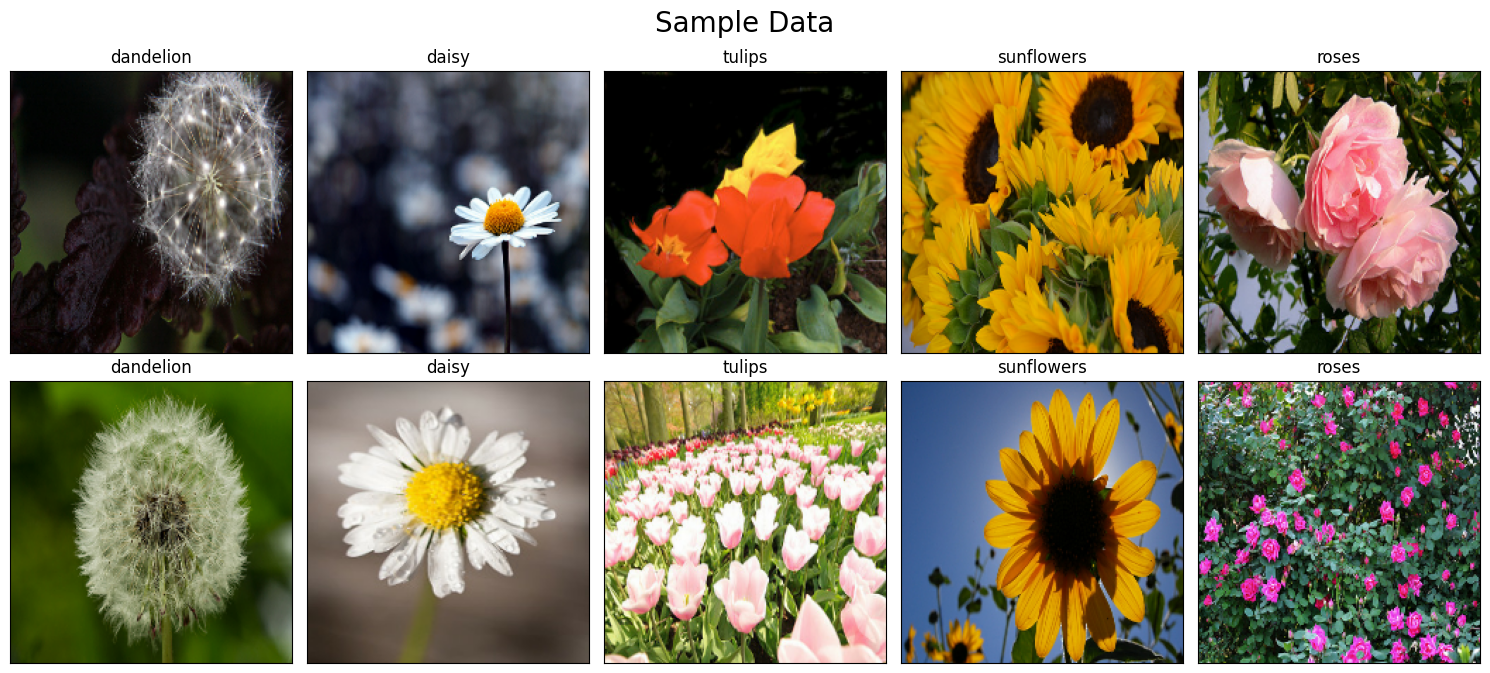

In [2]:
### DO NOT CHANGE ###
#@title Data Overview
#@markdown **<font color='red'>Note: you must run this cell, otherwise the later parts of the notebook won't run.</font>**
if __name__ == "__main__":
    import pathlib
    import numpy as np
    import matplotlib.pyplot as plt
    import tensorflow as tf

    # define constants
    SEED: int = 1636
    IMAGE_DIM: int = 200
    BATCH_SIZE: int = 32

    # set random seed to handle stochasticity
    tf.random.set_seed(SEED)

    # download and extract dataset
    dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
    data_dir = tf.keras.utils.get_file(origin=dataset_url, untar=True)

    # convert to pathlib.Path and point to the photos directory
    data_dir = pathlib.Path(data_dir) / "flower_photos"

    # load training dataset
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=SEED,
        image_size=(IMAGE_DIM, IMAGE_DIM),
        batch_size=BATCH_SIZE
    )

    # load validation dataset
    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=SEED,
        image_size=(IMAGE_DIM, IMAGE_DIM),
        batch_size=BATCH_SIZE
    )

    # get class names
    class_names: list[str] = train_ds.class_names

    # dictionary to store sample images for each category
    category_images: dict[str, list[np.ndarray]] = {class_name: [] for class_name in class_names}

    # loop through the training dataset and collect images for each category
    for images, labels in train_ds:
        # convert images and tensors to numpy arrays
        images: np.ndarray = images.numpy().astype("uint8")
        labels: np.ndarray = labels.numpy()

        for class_name in class_names:
            # get numeric label
            class_label = class_names.index(class_name)

            # get indices of this class
            indices = np.where(labels == class_label)[0]

            # store images in dictionary
            category_images[class_name].extend([images[i] for i in indices])

    # display 10 images, 2 of each category, in grid of 2 rows and 5 columns
    sample_images: list[list[tuple[np.ndarray, str]]] = [
        [
            (category_images["dandelion"][0], "dandelion"),
            (category_images["daisy"][4], "daisy"),
            (category_images["tulips"][0], "tulips"),
            (category_images["sunflowers"][10], "sunflowers"),
            (category_images["roses"][0], "roses")
        ],
        [
            (category_images["dandelion"][1], "dandelion"),
            (category_images["daisy"][1], "daisy"),
            (category_images["tulips"][1], "tulips"),
            (category_images["sunflowers"][4], "sunflowers"),
            (category_images["roses"][6], "roses")
        ],
    ]

    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 7))
    fig.suptitle(f"Sample Data", fontsize=20)
    for r, row in enumerate(axes):
        for c, _ in enumerate(row):
            ax = axes[r, c]
            img = sample_images[r][c][0]
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(img)
            ax.set_title(f"{sample_images[r][c][1]}")

    plt.tight_layout()

## Feed Forward Neural Networks (15 pts)

The first approach you will try is a Feed Forward Neural Network. This will serve as a baseline model for your experimentation.

**Note**: Although in practice, you'd design your own networks and iterate on them, for this problem set, **please design the network as specified**.

### FFNN Model (10 pts)

Build the `ffnn_model`. The architecture for the Neural Network for this section is:
- An input layer with the shape parameter set to `(200, 200, 3)` which corresponds to the dimensions of our images - this is already done for you
- A rescaling layer that converts the pixel values to a [0,1] range (for computational efficiency) - this is already done for you
- A flatten layer
- One hidden / dense layer with 256 nodes and activation `relu`
- One dropout layer with `dropout = 0.4`
- A second hidden / dense layer with 128 nodes and activation `relu`
- Output dense layer for our 5 classes; do not specify an activation function*

Please only modify the code in the areas specified. It maybe helpful to reference the Tensorflow documentation on [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers.

***Note**: With no activation function, it gives raw scores. With the `softmax` activation, it gives probabilities. Either case is fine as long as your downstream code handles it well. For this problem set, the former, raw scores, is expected downstream, hence the specification.

In [3]:
# define our Feed Forward Neural Network Model
ffnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(200, 200, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5)
])

After defining the model, we can compile and train it. Run the below the cell.

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.2609 - loss: 16.8638 - val_accuracy: 0.2520 - val_loss: 1.5404
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.2364 - loss: 1.5789 - val_accuracy: 0.3174 - val_loss: 1.5268
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.2931 - loss: 1.5124 - val_accuracy: 0.2738 - val_loss: 1.4801
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.3180 - loss: 1.5076 - val_accuracy: 0.3283 - val_loss: 1.4490
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.2956 - loss: 1.5000 - val_accuracy: 0.2180 - val_loss: 1.5244
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.2660 - loss: 1.5585 - val_accuracy: 0.2112 - val_loss: 1.5258
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.2567 - loss: 1.5851 - val_accuracy: 0.2166 - val_loss: 1.5452
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.2602 - loss: 1.5457 - val_accuracy: 0.2180

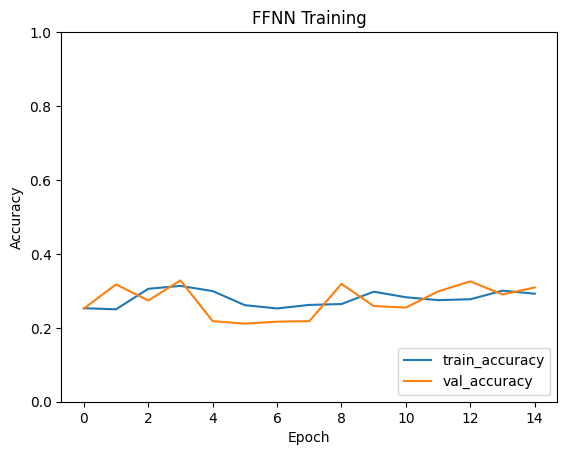

In [4]:
### DO NOT CHANGE ###
#@title Run to Compile & Train the FFNN Model
#@markdown If you run into issues / errors, make sure to execute / run all the above code cells and / or double check your network implementation (*note: you can validate if your model implementation is correct by submitting on gradescope which will provide feedback*).
if __name__ == "__main__":
    import numpy as np
    import matplotlib.pyplot as plt
    import tensorflow as tf
    import tensorflow_hub as hub

    # custom exception
    class StopExecution(Exception):
        """Custom execution handler."""
        def _render_traceback_(self):
            """Suppress long exception message."""
            pass

    # custom print statements
    def printRB(text: str) -> None:
        """Prints red and bold."""
        red_bold = "\033[1;31m"
        reset = "\033[0m"
        print(f"{red_bold}{text}{reset}")

    # check if variables are loaded
    try:
        train_ds
        val_ds
    except NameError as e:
        printRB(
            "ERROR: It appears that the data preparation code cell "
            f"was not executed; please run the above data preparation cell!\n"
            f"Encounter exception with message: {e}"
        )
        raise StopExecution

    try:
        ffnn_model
    except NameError as e:
        printRB(
            "ERROR: It appears that the `ffnn_model` code cell "
            f"was not executed; please run the above code cell!\n"
            f"Encounter exception with message: {e}"
        )
        raise StopExecution

    tf.random.set_seed(17)

    # compile model
    ffnn_model.compile(optimizer='adam',
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                       metrics=['accuracy'])
    # train model
    EPOCH = 15
    ffnn_history = ffnn_model.fit(train_ds, epochs=EPOCH,
                    validation_data=val_ds)

    # visualize the training history and get the performance
    plt.plot(ffnn_history.history['accuracy'], label='train_accuracy')
    plt.plot(ffnn_history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title("FFNN Training")
    plt.legend(loc='lower right')

In [11]:
#@title Evaluate the Model (5 pts)

#@markdown What was the highest validation accuracy achieved by the Feed Forward Neural Network (as a number between 0 to 1)?

#@markdown **Note**: due to the stochastic nature of Neural Network training, you will get a different validation accuracy each time you train it. This is expected and the answer will be marked correct if it falls within the expected range - it may be beneficial to train and evaluate the model several times to see the pattern in the validation accuracy (your answer can be average accuracy observed over 3-5 runs).

#@markdown **In terms of numeric precision, please have 4 decimal point precision (if applicable) (e.g., 3.1415 has 4 decimal point precision). Additionally, only provide the numeric answer (do not include any units or other text in the answer field).**
ffnn_highest_val_acc = "0.3161" #@param {type:"string"}

Feed Forward Neural Network generally struggle with image data due to the spatial elements and patterns in the data. Let's experiment with convolutional neural networks which generally perform better with images.

## Convolutional Neural Networks (15 pts)

The second approach you will try is a Convolutional Neural Network. Ideally, there should be a significant improvement in accuracy.

### CNN Model (10 pts)

Build the `cnn_model` (10 pts). The architecture for the Neural Network for this section is:
- An input layer with the shape parameter set to `(200, 200, 3)` which corresponds to the dimensions of our images
- A rescaling layer that converts the pixel values to a [0,1] range (for computational efficiency)
- An initial 2D convolutional layer of 32 filters with kernel size $5 \times 5$, padding `same`, and activation `relu`
- One 2D max pooling layer with a pool size of (2, 2)
- A second 2D convolutional layer of 64 filters with kernel size $3 \times 3$, padding `same`, and activation `relu`
- A second 2D max pooling layer with pool size of (2, 2)
- A third 2D convolutional layer of 32 filters with kernel size $3 \times 3$, padding `same`, and activation `relu`
- A third 2D max pooling layer with pool size of (2, 2)
- A flattening layer
- One hidden / dense layer with 512 nodes and activation `relu`
- One dropout layer with `dropout = 0.4`
- One hidden / dense layer with 128 nodes and activation `relu`
- Output dense layer for our 5 classes; do not specify an activation function*

Please only modify the code in the areas specified. It maybe helpful to reference the Tensorflow documentation on [`Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling), [`Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D), [`MaxPooling2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D), [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers.

***Note**: With no activation function, it gives raw scores. With the `softmax` activation, it gives probabilities. Either case is fine as long as your downstream code handles it well. For this problem set, the former, raw scores, is expected downstream, hence the specification.

In [12]:
# define our Convolutional Neural Network Model
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(200, 200, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5)
])

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.3248 - loss: 1.5001 - val_accuracy: 0.4537 - val_loss: 1.1779
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.5340 - loss: 1.1397 - val_accuracy: 0.5681 - val_loss: 1.1244
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.6267 - loss: 0.9951 - val_accuracy: 0.6063 - val_loss: 0.9978
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.6849 - loss: 0.8231 - val_accuracy: 0.6335 - val_loss: 0.9923
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.7521 - loss: 0.6646 - val_accuracy: 0.6349 - val_loss: 1.1125
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.8246 - loss: 0.4900 - val_accuracy: 0.6403 - val_loss: 1.1730
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.8556 - loss: 0.3930 - val_accuracy: 0.6131 - val_loss: 1.5913
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.9204 - loss: 0.2303 - val_accuracy: 0.6431 - v

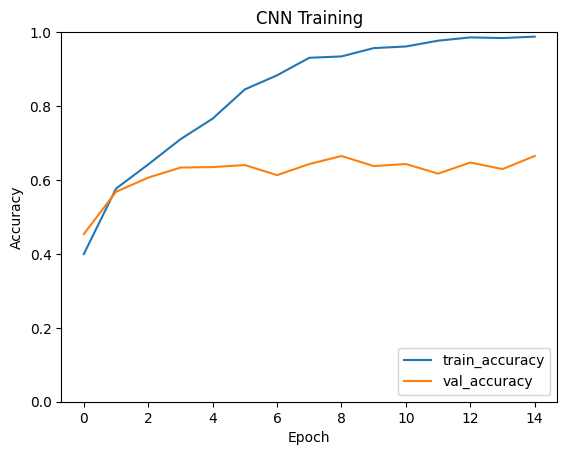

In [13]:
### DO NOT CHANGE ###
#@title Run to Compile & Train the CNN Model
#@markdown If you run into issues / errors, make sure to execute / run all the above code cells and / or double check your network implementation (*note: you can validate if your model implementation is correct by submitting on gradescope which will provide feedback*).
if __name__ == "__main__":
    import numpy as np
    import matplotlib.pyplot as plt
    import tensorflow as tf
    import tensorflow_hub as hub

    # custom exception
    class StopExecution(Exception):
        """Custom execution handler."""
        def _render_traceback_(self):
            """Suppress long exception message."""
            pass

    # custom print statements
    def printRB(text: str) -> None:
        """Prints red and bold."""
        red_bold = "\033[1;31m"
        reset = "\033[0m"
        print(f"{red_bold}{text}{reset}")

    # check if variables are loaded
    try:
        train_ds
        val_ds
    except NameError as e:
        printRB(
            "ERROR: It appears that the data preparation code cell "
            f"was not executed; please run the above data preparation cell!\n"
            f"Encounter exception with message: {e}"
        )
        raise StopExecution

    try:
        cnn_model
    except NameError as e:
        printRB(
            "ERROR: It appears that the `cnn_model` code cell "
            f"was not executed; please run the above code cell!\n"
            f"Encounter exception with message: {e}"
        )
        raise StopExecution

    tf.random.set_seed(17)

    # compile model
    cnn_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
    # train model
    EPOCH = 15
    cnn_history = cnn_model.fit(train_ds, epochs=EPOCH,
                    validation_data=val_ds)

    # visualize the training history and get the performance
    plt.plot(cnn_history.history['accuracy'], label='train_accuracy')
    plt.plot(cnn_history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title("CNN Training")
    plt.legend(loc='lower right')

In [14]:
#@title Evaluate the Model (5 pts)

#@markdown What was the highest validation accuracy achieved by the Convolutional Neural Network (as a number between 0 to 1)?

#@markdown **Note**: due to the stochastic nature of Neural Network training, you will get a different validation accuracy each time you train it. This is expected and the answer will be marked correct if it falls within the expected range - it may be beneficial to train and evaluate the model several times to see the pattern in the validation accuracy (your answer can be average accuracy observed over 3-5 runs).

#@markdown **In terms of numeric precision, please have 4 decimal point precision (if applicable) (e.g., 3.1415 has 4 decimal point precision). Additionally, only provide the numeric answer (do not include any units or other text in the answer field).**
cnn_highest_val_acc = "0.6649" #@param {type:"string"}

Both models we've considered so far have been trained from scratch. In general, it can be advantageous to start with a model that has already been pre-trained on some other dataset. The pre-trained model can leverage knowledge from its previous training for its new task - hence this practice is called transfer learning. Let's experiment with pre-trained models and transfer learning.

## Pre-Trained Neural Networks & Transfer Learning (15 pts)

The final approach you will try is a Pre-Trained Neural Network with some fine-tuning. Ideally, there should be a significant improvement in accuracy.

### Transfer Model (10 pts)

Build the `transfer_model` (10 pts). The architecture for the Neural Network for this section is:
- An input layer with the shape parameter set to `(200, 200, 3)` which corresponds to the dimensions of our images
- A rescaling layer that converts the pixel values to a [0,1] range (for computational efficiency)
- A pre-trained base model feature extractor
- A global average pooling 2D layer
- One dense layer of 128 nodes and activation `relu`
- One dropout layer with `dropout = 0.4`
- Output dense layer for our 5 classes; do not specify an activation function*

Please only modify the code in the areas specified. It maybe helpful to reference the Tensorflow documentation on [`Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling), [`GlobalAveragePooling2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D), [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), and [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layers.

***Note**: With no activation function, it gives raw scores. With the `softmax` activation, it gives probabilities. Either case is fine as long as your downstream code handles it well. For this problem set, the former, raw scores, is expected downstream, hence the specification.

In [15]:
# get the pre-trained model and freeze the weights
base_model = tf.keras.applications.MobileNetV2(input_shape=(200, 200, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

# define our Pre-Trained Neural Network Model
transfer_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(200, 200, 3)),
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(5)
])

/tmp/ipython-input-15-3386959929.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(200, 200, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.6229 - loss: 0.9783 - val_accuracy: 0.8774 - val_loss: 0.3711
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8503 - loss: 0.4121 - val_accuracy: 0.8978 - val_loss: 0.3357
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.8847 - loss: 0.3203 - val_accuracy: 0.8951 - val_loss: 0.3315
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.9114 - loss: 0.2467 - val_accuracy: 0.8787 - val_loss: 0.3495
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.9349 - loss: 0.2035 - val_accuracy: 0.8937 - val_loss: 0.3327
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.9396 - loss: 0.1719 - val_accuracy: 0.8883 - val_loss: 0.3344
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9499 - loss: 0.1349 - val_accuracy: 0.8937 - val_loss: 0.3449
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9585 - loss: 0.1175 - val_accuracy: 0.8787 - v

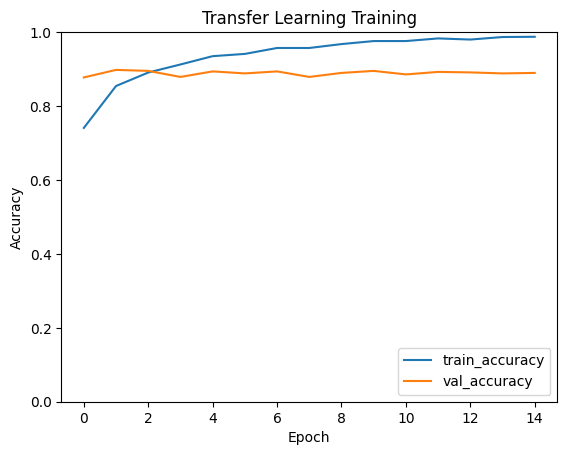

In [16]:
### DO NOT CHANGE ###
#@title Run to Compile & Finetune the Pre-Trained Model
#@markdown If you run into issues / errors, make sure to execute / run all the above code cells and / or double check your network implementation (*note: you can validate if your model implementation is correct by submitting on gradescope which will provide feedback*).
if __name__ == "__main__":
    import numpy as np
    import matplotlib.pyplot as plt
    import tensorflow as tf
    import tensorflow_hub as hub

    # custom exception
    class StopExecution(Exception):
        """Custom execution handler."""
        def _render_traceback_(self):
            """Suppress long exception message."""
            pass

    # custom print statements
    def printRB(text: str) -> None:
        """Prints red and bold."""
        red_bold = "\033[1;31m"
        reset = "\033[0m"
        print(f"{red_bold}{text}{reset}")

    # check if variables are loaded
    try:
        train_ds
        val_ds
    except NameError as e:
        printRB(
            "ERROR: It appears that the data preparation code cell "
            f"was not executed; please run the above data preparation cell!\n"
            f"Encounter exception with message: {e}"
        )
        raise StopExecution

    try:
        transfer_model
    except NameError as e:
        printRB(
            "ERROR: It appears that the `transfer_model` code cell "
            f"was not executed; please run the above code cell!\n"
            f"Encounter exception with message: {e}"
        )
        raise StopExecution

    tf.random.set_seed(17)

    # compile model
    transfer_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
    # train model
    EPOCH = 15
    transfer_history = transfer_model.fit(train_ds, epochs=EPOCH,
                    validation_data=val_ds)

    # visualize the training history and get the performance
    plt.plot(transfer_history.history['accuracy'], label='train_accuracy')
    plt.plot(transfer_history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.title("Transfer Learning Training")
    plt.legend(loc='lower right')

In [17]:
#@title Evaluate the Model (5 pts)

#@markdown What was the highest validation accuracy achieved by the Fine-Tuned Pre-Trained Neural Network (as a number between 0 to 1)?

#@markdown **Note**: due to the stochastic nature of Neural Network training, you will get a different validation accuracy each time you train it. This is expected and the answer will be marked correct if it falls within the expected range - it may be beneficial to train and evaluate the model several times to see the pattern in the validation accuracy (your answer can be average accuracy observed over 3-5 runs).

#@markdown **In terms of numeric precision, please have 4 decimal point precision (if applicable) (e.g., 3.1415 has 4 decimal point precision). Additionally, only provide the numeric answer (do not include any units or other text in the answer field).**
transfer_highest_val_acc = "0.8978" #@param {type:"string"}

## Conclusion (15 pts)

Congrats! You've built three distinct deep learning, neural network models. Answer the below concept check questions and choose the most correct option.

In [18]:
#@title Best Model (3 pts)

#@markdown Which model was the best performing (in terms of validation accuracy)?
best_model = "Fine-Tuned Pre-Trained Neural Network (Transfer Learning)" #@param ["", "Feed Forward Neural Network", "Convolutional Neural Network", "Fine-Tuned Pre-Trained Neural Network (Transfer Learning)"]

In [19]:
#@title Most Overfitted Model (3 pts)

#@markdown Which model demonstrated the most overfitting (i.e., learns the training data very well but fails to generalize on the validation data)?
most_overfitted_model = "Convolutional Neural Network" #@param ["", "Feed Forward Neural Network", "Convolutional Neural Network", "Fine-Tuned Pre-Trained Neural Network (Transfer Learning)"]

In [20]:
#@title Increase Number of Epochs (3 pts)

#@markdown In general, what should you expect for the accuracy as you increase the number of epochs?
increase_num_of_epochs = "The training accuracy should increase but the validation accuracy may not necessarily always increase" #@param ["", "The training accuracy should increase but the validation accuracy may not necessarily always increase", "The validation accuracy should increase but the training accuracy may not necessarily always increase", "Both the training and validation accuracy should always keep increasing", "There is no relationship between the number of epochs and training / validation accuracy"]

In [21]:
#@title Increase Complexity (3 pts)

#@markdown In general, what should you expect for the accuracy as you increase the complexity (number of components and layers) of your model?
increase_complexity = "The training accuracy will increase as the model will underfit and the validation accuracy will go down as the model fails to generalize" #@param ["", "The training and validation accuracy will increase as the model is able to handle more complex patterns", "The training accuracy will increase as the model will underfit and the validation accuracy will go down as the model fails to generalize", "The training accuracy will improve to a point but the validation accuracy should keep improving", "The validation accuracy will improve to a point but the training accuracy should keep improving"]

In [22]:
#@title Worst Situation (3 pts)

#@markdown In general, which of the following situations would the model you built here perform the worst in?
worst_situation = "A drone fleet system to monitor and track farm animals" #@param ["", "An app for gardeners to identify different flower species in their garden", "A drone fleet system to monitor and track farm animals", "A research project on invasive flower species in New England forests", "Classifying different vegetation and trees along coastal areas"]

You may have noticed that there is still room for improvement on the validation accuracy - the next step as the Machine Learning lead would be to experiment and try different models to acheive a high validation accuracy. In general, a high validation accuracy translates to better performance in application.

If you are interested in improving the validation accuracy of your model, explore the extra credit section.

## EXTRA CREDIT: Custom Neural Network (10-20 pts)

**Note**: This section is optional extra credit for all credit status (undergraduates and graduate students). This section is intended for students looking for more depth or advanced material. This section may require additional self-study to complete. Since this is extra credit, assistance from Gradescope will be limited. Furthermore, there will be limited support from course staff, office hours, and Ed discussion.

So far, you've been building neural networks prescriptively based on the specifications. For extra credit, design your own custom neural network. You are free to leverage any pre-trained models, implement custom architectures, and set  hyperparameters. You are also free to use either TensorFlow or PyTorch (either will suffice) and any pre-trained model(s).

If your model achieves **at least 94% accuracy on the validation set, you'll get 10 extra credit points**. If your model achieves **at least 97% accuracy on the validation set, you'll get 20 extra credit points**.

In terms of work and submission, **please do this in a separate notebook altogether**. Once you've designed a neural network that acheives the minimum validation accuracy, **please email your notebook submission to the course staff at harvard.dgmd17@gmail.com**.

The reason for a separate notebook is because this section is very open-ended (i.e., many ways of doing it) and course staff will grade it separately.

In terms of the data, the dataset for this problem set is an open source dataset, called [`tf_flowers`](https://www.tensorflow.org/datasets/catalog/tf_flowers). You can either download / access it in which ever method you find most convenient from online or you can copy the code in the Context & Data Preparation section which downloads it for you.

In terms of grading, the course staff will review and execute your notebook with the validation set - please make check that the code runs with no errors (so explicitly disconnect your runtime and re-run everything to make sure it works). Additionally, label or clearly document which section is the final model versus your experiments / prototypes.

## Problem Set Survey (5 pts)

Please fill out the survey questions (the first five are each worth 1 point; the last one is optional).


1.   `TIME` (1 pt): approximately how many hours did you spend on the problem set? Please use decimals to express partial hours (e.g., a value of `2.5` means two and half hours).
2.   `DIFFICULTY` (1 pt): on a scale of 1-10, how difficult was this problem set with 1 being very easy and 10 being very hard?
3.   `FAVORITE_PART` (1 pt): What was your favorite topic / learning from the unit (i.e., between the last pset and this pset)? This should contain at least 10 words.
4.   `WENT_WELL` (1 pt): What went well? Describe what went well with the course so far (this can be about the lecture, assignments, and/or other course content). This should contain at least 10 words.
5.   `CHALLENGING` (1 pt): What was challenging? Describe what was challenging or didn't go well with the course so far (this can be about the lecture, assignments, and/or other course content). This should contain at least 10 words.
6.   `COMMENTARY` (0 pt): If there is anything else you'd like to share with course staff, please add it here. You can also mention any resources you used (include generative AI) or any students you collaborated with here as well. If there is nothing to share, no need to change / edit the default value.

In [23]:
#@title Problem Set Survey Questions
TIME = "4" #@param {type:"string"}

DIFFICULTY = "4" #@param ["", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

FAVORITE_PART = "My favorite part was analyzing the results that the different neural nets achieved and how they differed from each other." #@param {type:"string"}

WENT_WELL = "I was able to make the different models pretty easily following the instructions." #@param {type:"string"}

CHALLENGING = "The time taken to train the models was a lot more than I expected (around 1 hour per model)" #@param {type:"string"}

COMMENTARY = "" #@param {type:"string"}

**<font color='red'>To submit, please download as a Python (.py) file and submit on Gradescope (navigate to File > Download > Download .py). Please use the correct file name and comment out any test / extraneous code to avoid any compile and parser issues </font>**